In [1]:
# Imports
from IPython.display import Image, display # notebook image visualisations
import numpy as np
import cv2 # opencv
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy.interpolate import griddata
from scipy.ndimage import zoom
import xarray as xr
from tqdm.notebook import tqdm # requires ipywidgets

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from A_helper_functions import *

# $\Delta V$ estimation

## Source File
extracted .png file from IAC 18 publication pdf

https://keldysh.ru/microsatellites/IAC_18_Trofimov_paper.pdf

In [ ]:
display(Image(filename='maps/preparation/NRHO/original.png',width=600))

Source image is from Matlab Jet colormap

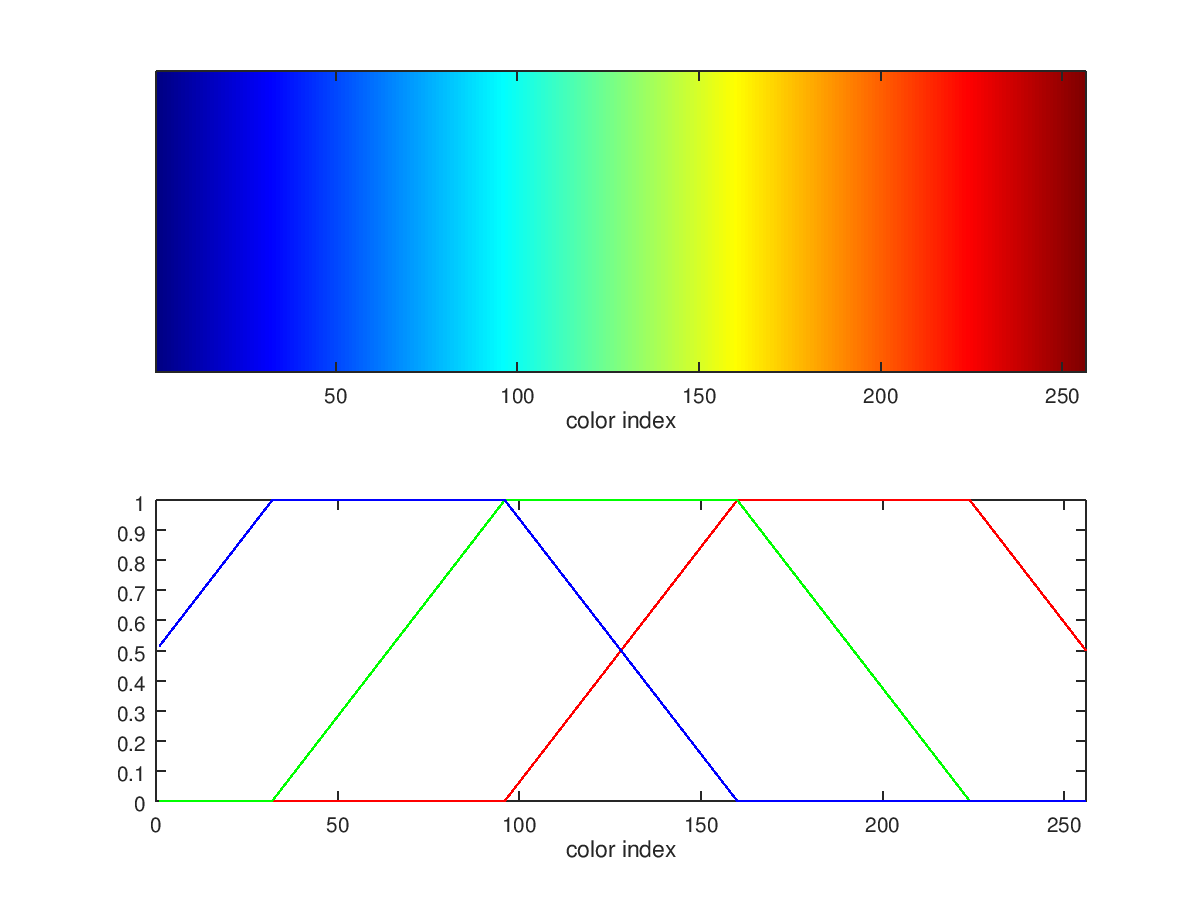

https://octave.sourceforge.io/octave/function/jet.html

In [4]:
# handcrafting all colors (BGR) from jet together in full 8-bit
# (matplotlib jet is slightly different)
# create mapping to dv values

jet_colormap_colors = []
mapping = {}

# 2.4 - 2.6
for i in np.arange(128,256,1):
    pixel = [i,0,0] 
    jet_colormap_colors.append(pixel)
    mapping[str(pixel)] = 0

# 2.6 - 2.8
for i in np.arange(0,256,1):
    pixel = [255,i,0] 
    jet_colormap_colors.append(pixel)
    mapping[str(pixel)] = 0

# 2.8 - 3.0
for i in np.arange(0,256,1):
    pixel = [255-i,255,i]
    jet_colormap_colors.append(pixel)
    mapping[str(pixel)] = 0

# 3.0 - 3.2
#for i in np.arange(0,256,1):
#    pixel = [0,255-i,255]
#    jet_colormap_colors.append(pixel)
#    mapping[str(pixel)] = None


# known values
mapping[str([255,80,0]   )] = 2600 # [m/s]
mapping[str([207,255,48] )] = 2800 # [m/s]

# from 2600 to 2800 number of steps
intermediates = (255-80) + (48)
step = (2800-2600) / intermediates

# compute first entry '[128, 0, 0]'
first_value = 2600 - ( (80+255-128)* step)

for i , val in enumerate(mapping):
    mapping[str(val)] = round(first_value + step*i,2)

# add zero
mapping[str([0,0,0])] = None # used when no value

print(jet_colormap_colors[0:5],' ... ',jet_colormap_colors[-5:])
mapping

[[128, 0, 0], [129, 0, 0], [130, 0, 0], [131, 0, 0], [132, 0, 0]]  ...  [[4, 255, 251], [3, 255, 252], [2, 255, 253], [1, 255, 254], [0, 255, 255]]


{'[128, 0, 0]': 2414.35,
 '[129, 0, 0]': 2415.25,
 '[130, 0, 0]': 2416.14,
 '[131, 0, 0]': 2417.04,
 '[132, 0, 0]': 2417.94,
 '[133, 0, 0]': 2418.83,
 '[134, 0, 0]': 2419.73,
 '[135, 0, 0]': 2420.63,
 '[136, 0, 0]': 2421.52,
 '[137, 0, 0]': 2422.42,
 '[138, 0, 0]': 2423.32,
 '[139, 0, 0]': 2424.22,
 '[140, 0, 0]': 2425.11,
 '[141, 0, 0]': 2426.01,
 '[142, 0, 0]': 2426.91,
 '[143, 0, 0]': 2427.8,
 '[144, 0, 0]': 2428.7,
 '[145, 0, 0]': 2429.6,
 '[146, 0, 0]': 2430.49,
 '[147, 0, 0]': 2431.39,
 '[148, 0, 0]': 2432.29,
 '[149, 0, 0]': 2433.18,
 '[150, 0, 0]': 2434.08,
 '[151, 0, 0]': 2434.98,
 '[152, 0, 0]': 2435.87,
 '[153, 0, 0]': 2436.77,
 '[154, 0, 0]': 2437.67,
 '[155, 0, 0]': 2438.57,
 '[156, 0, 0]': 2439.46,
 '[157, 0, 0]': 2440.36,
 '[158, 0, 0]': 2441.26,
 '[159, 0, 0]': 2442.15,
 '[160, 0, 0]': 2443.05,
 '[161, 0, 0]': 2443.95,
 '[162, 0, 0]': 2444.84,
 '[163, 0, 0]': 2445.74,
 '[164, 0, 0]': 2446.64,
 '[165, 0, 0]': 2447.53,
 '[166, 0, 0]': 2448.43,
 '[167, 0, 0]': 2449.33,
 '[

## crop canvas from orginal image
done in picture editing software - Paint.NET

In [26]:
# maps/preparation/NRHO/original.png

## transfer only jet colormap colors into canvas_edit

In [5]:
jet_colormap_image  = cv2.imread('maps/preparation/NRHO/canvas.png')

jet_color_mask = np.zeros(jet_colormap_image.shape[:2], dtype=np.uint8)

for color in tqdm(jet_colormap_colors):
    lower_bound = np.array(color)
    upper_bound = np.array(color)
    jet_color_mask += cv2.inRange(jet_colormap_image, lower_bound, upper_bound)

result_image = cv2.bitwise_and(jet_colormap_image, jet_colormap_image, mask=jet_color_mask)

rgba_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2BGRA)
black_pixels = np.all(rgba_image[:, :, :3] == [0, 0, 0], axis=-1)
rgba_image[black_pixels, 3] = 0  # Set alpha channel to 0 for black pixels

cv2.imwrite('maps/preparation/NRHO/canvas_edit.png', rgba_image)

  0%|          | 0/640 [00:00<?, ?it/s]

True

In [ ]:
display(Image(filename='maps/preparation/NRHO/canvas_edit.png',width=600))

## Tile the cavas_edit and take the minimum for the whole tile

In [6]:
def find_minimum_pixel_by_jet_colormap(image):
    rows, cols, _ = image.shape

    min_pixel = None
    min_jet_index = float('inf')

    pixels_1d = image.reshape(-1, 3)
    unique_pixels = np.unique(pixels_1d, axis=0)

    for i in unique_pixels:
            blue_value = i[0]
            green_value = i[1]
            red_value = i[2]

            if blue_value == 0 and green_value == 0 and red_value == 0:
                pass
            else:
                jet_index = blue_value + 256 * green_value + 256 * 256 * red_value
    
                if jet_index < min_jet_index:
                    min_jet_index = jet_index
                    min_pixel = i

    if min_pixel is None:
        min_pixel = [0,0,0]
    return min_pixel

In [24]:
img = cv2.imread('maps/preparation/NRHO/canvas_edit.png') # [0] Blue [1] Green [2] Red
print(img.shape)

# original map had non equal axis scaling
# 6 x 30° Lat height
# 8 x 45° Lon width
# 3729 x 2721 resolution


# square tiles in degrees
tile_deg_res = 20 # [deg]

# create tile height
#tile_height = 30/res_div # deg
divider_h = 180/tile_deg_res
tile_height_px = int(img.shape[0]/divider_h) # px

# create tile width
#tile_width = 45/res_div # deg
divider_w = 360/tile_deg_res
tile_width_px = int(img.shape[1]/divider_w) # px

Lat = int(img.shape[0] / tile_height_px)
Lon = int(img.shape[1] / tile_width_px)

print(Lat,Lon)

# for X-Array result
dv_map_NRHO_raw = np.zeros((Lat,Lon))

for i in tqdm(range(Lat)):
    for j in range(Lon):
        
        begin_height = i * tile_height_px
        end_heigth =  (i+1) * tile_height_px
        begin_width = j * tile_width_px
        end_width = (j+1) * tile_width_px
        
        #print(f"Tile {i} {j} going from [{begin_height} : {end_heigth}] and [{begin_width} : {end_width}]")
        tile_px = img[begin_height:end_heigth,begin_width:end_width]
        #cv2.imwrite(f'maps/preparation/NRHO/tiles/tile_{i}_{j}.png', tile_px)

        min = find_minimum_pixel_by_jet_colormap(tile_px)
        min_to_str = [min[0],min[1],min[2]]
        
        dv_map_NRHO_raw[i,j] =  mapping[str(min_to_str)]
        img[begin_height:end_heigth,begin_width:end_width] = min

rgba_image = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
black_pixels = np.all(rgba_image[:, :, :3] == [0, 0, 0], axis=-1)
rgba_image[black_pixels, 3] = 0  # Set alpha channel to 0 for black pixels

cv2.imwrite('maps/preparation/NRHO/canvas_tiled.png', rgba_image)

(2721, 3729, 3)
9 18


  0%|          | 0/9 [00:00<?, ?it/s]

True

In [ ]:
display(Image(filename='maps/preparation/NRHO/canvas_tiled.png',width=600))

## interpolate missing tile data from neighbor tiles

In [25]:
dv_map_NRHO_raw

array([[2509.42, 2424.22, 2600.9 , 2417.04, 2417.04, 2489.69, 2449.33,
        2414.35, 2526.46, 2426.91, 2414.35, 2414.35, 2416.14, 2415.25,
        2418.83, 2447.53, 2440.36, 2439.46],
       [2477.13, 2514.8 , 2539.91, 2553.36, 2526.46, 2502.24, 2449.33,
        2487.89, 2427.8 , 2415.25, 2414.35, 2417.04, 2417.94, 2423.32,
        2425.11, 2453.81, 2449.33, 2483.41],
       [2521.08, 2610.76, 2553.36, 2553.36, 2526.46, 2554.26, 2540.81,
        2513.  , 2454.71, 2429.6 , 2418.83, 2426.01, 2435.87, 2445.74,
        2452.02, 2465.47, 2530.04, 2528.25],
       [2643.05, 2660.09, 2690.58, 2649.33, 2652.02, 2631.39, 2593.72,
        2574.89, 2516.59, 2460.99, 2452.02, 2452.02, 2460.99, 2492.38,
        2504.93, 2523.77, 2621.52, 2606.28],
       [2727.35, 2798.21, 2782.96, 2761.43, 2740.81, 2730.94, 2674.44,
        2632.29, 2597.31, 2579.37, 2521.97, 2520.18, 2565.92, 2576.68,
        2595.52, 2719.28, 2713.  , 2731.84],
       [2818.83, 2828.7 , 2852.91, 2855.61, 2816.14, 2828.7 , 274

In [30]:
data = dv_map_NRHO_raw

# Iterate through each row and perform interpolation
# assumes high Longitudinal consistency at poles

for row_idx in range(data.shape[0]):
    row = data[row_idx]
    nan_indices = np.isnan(row)
    not_nan_indices = ~nan_indices
    
    if np.any(nan_indices):
        row_interp = np.interp(nan_indices.nonzero()[0], not_nan_indices.nonzero()[0], row[not_nan_indices])
        row[nan_indices] = row_interp

dv_map_NRHO = data

In [31]:
# save into x-Array

Lon = np.arange(-180+tile_deg_res/2, 180,tile_deg_res)
Lat = np.arange(-90+tile_deg_res/2, 90,tile_deg_res)

xA_dv_map_NRHO = xr.DataArray(
    data=dv_map_NRHO,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="DeltaV for direct transfer from Lunar Surface to Lunar Gateway (Southern 9:2 NRHO)",
        var_desc="$\Delta v$",
        units="m/s",
    ),
)

xA_dv_map_NRHO.to_netcdf("maps/dv_map_NRHO.nc")
xA_dv_map_NRHO

<xarray.DataArray (lat: 9, lon: 18)>
array([[2509.42      , 2424.22      , 2600.9       , 2417.04      ,
        2417.04      , 2489.69      , 2449.33      , 2414.35      ,
        2526.46      , 2426.91      , 2414.35      , 2414.35      ,
        2416.14      , 2415.25      , 2418.83      , 2447.53      ,
        2440.36      , 2439.46      ],
       [2477.13      , 2514.8       , 2539.91      , 2553.36      ,
        2526.46      , 2502.24      , 2449.33      , 2487.89      ,
        2427.8       , 2415.25      , 2414.35      , 2417.04      ,
        2417.94      , 2423.32      , 2425.11      , 2453.81      ,
        2449.33      , 2483.41      ],
       [2521.08      , 2610.76      , 2553.36      , 2553.36      ,
        2526.46      , 2554.26      , 2540.81      , 2513.        ,
        2454.71      , 2429.6       , 2418.83      , 2426.01      ,
        2435.87      , 2445.74      , 2452.02      , 2465.47      ,
        2530.04      , 2528.25      ],
       [2643.05      , 2660.09      , 2690.58      , 2649.33      ,
        2652.02      , 2631.39      , 2593.72      , 2574.89      ,
        2516.59      , 2460.99      , 2452.02      , 2452.02      ,
        2460.99      , 2492.38      , 2504.93      , 2523.77      ,
        2621.52      , 2606.28      ],
...
       [2818.83      , 2828.7       , 2852.91      , 2855.61      ,
        2816.14      , 2828.7       , 2748.88      , 2735.43      ,
        2741.7       , 2746.19      , 2618.83      , 2604.48      ,
        2632.29      , 2664.57      , 2684.3       , 2822.42      ,
        2814.35      , 2814.35      ],
       [2881.61      , 2876.23      , 2912.11      , 2958.74      ,
        2902.24      , 2834.08      , 2850.22      , 2841.26      ,
        2830.49      , 2837.67      , 2775.78      , 2730.94      ,
        2735.43      , 2740.81      , 2830.49      , 2864.57      ,
        2884.3       , 2895.96      ],
       [2956.95      , 2977.58      , 2934.53      , 2950.67      ,
        2935.43      , 2904.93      , 2887.        , 2876.23      ,
        2876.23      , 2883.41      , 2845.74      , 2936.32      ,
        2916.59      , 2881.61      , 2881.61      , 2953.36      ,
        2961.43      , 2948.88      ],
       [2973.99      , 2973.99      , 2973.99      , 2981.17      ,
        2971.3       , 2971.3       , 2974.89      , 2976.68      ,
        2974.89      , 2972.2       , 2973.39333333, 2974.58666667,
        2975.78      , 2982.06      , 2982.9575    , 2983.855     ,
        2984.7525    , 2985.65      ]])
Coordinates:
  * lon      (lon) float64 -170.0 -150.0 -130.0 -110.0 ... 130.0 150.0 170.0
  * lat      (lat) float64 -80.0 -60.0 -40.0 -20.0 0.0 20.0 40.0 60.0 80.0
Attributes:
    description:  DeltaV for direct transfer from Lunar Surface to Lunar Gate...
    var_desc:     $\Delta v$
    units:        m/s

In [3]:
# load xArray from file
xA_dv_map_NRHO = xr.open_dataarray("maps/dv_map_NRHO.nc")
dv_map_NRHO = xA_dv_map_NRHO.data

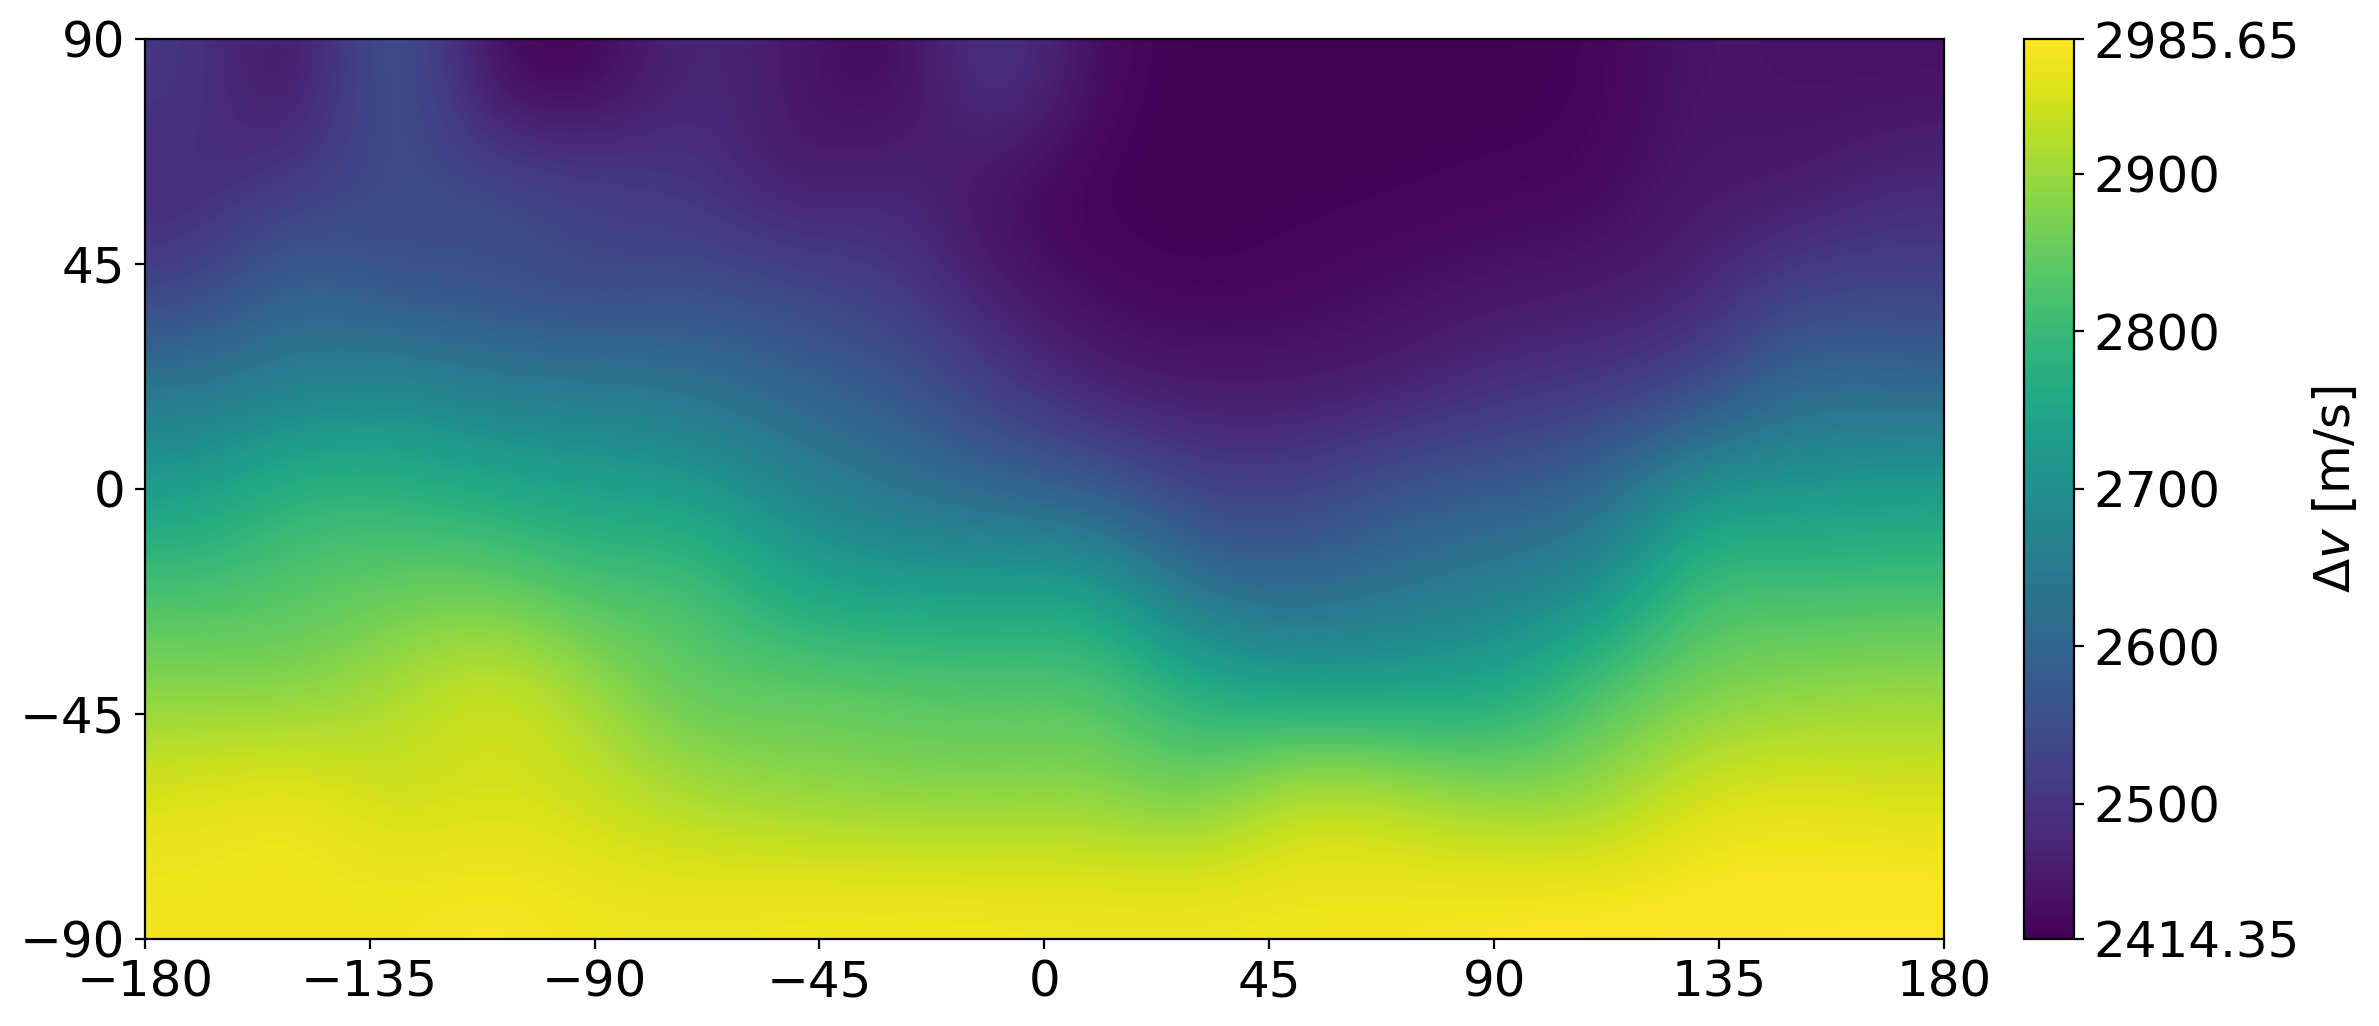

In [99]:
upscaled_array = plot_map(dv_map_NRHO,1,'$\Delta v$ [m/s]',tuple((-90,90)),tuple((-180,180)),i_steps=[2500,2600,2700,2800,2900],silent=True,interpolation='bicubic',return_data=True,labelsize=18,save="dv_NRHO.pdf")

In [5]:
upscaled_array.shape

(9, 18)

In [ ]:
import numpy as np
from scipy.ndimage import zoom

data = dv_map_NRHO

upscaled_data = zoom(data, 3000, mode='constant', order=3, grid_mode=False) # cubic interpolation (order=3)
upscaled_array = np.clip(upscaled_data, data.min(), data.max()) # Clip the values to the original data range

print(upscaled_array.shape)


In [7]:
np.linspace(0, 6, 4)

array([0., 2., 4., 6.])

In [6]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Create a sample numpy array and its coordinates
original_data = np.array([[1, 2, 3],
                           [4, 5, 6]])
x = np.arange(original_data.shape[0])
y = np.arange(original_data.shape[1])

# Define the desired grid points for the resized array
new_x = np.linspace(0, x[-1], 4)  # Adjust as needed
new_y = np.linspace(0, y[-1], 6)  # Adjust as needed

# Create a RegularGridInterpolator object
interpolator = RegularGridInterpolator((x, y), original_data, method='linear', bounds_error=False, fill_value=None)

# Generate the coordinates for the new grid
new_coordinates = np.array(np.meshgrid(new_x, new_y, indexing='ij')).T.reshape(-1, 2)

# Perform interpolation to resize the array
resized_array = interpolator(new_coordinates).reshape(new_x.shape[0], new_y.shape[0])

print("Original Array:")
print(original_data)
print("Resized Array with Interpolation:")
print(resized_array)


Original Array:
[[1 2 3]
 [4 5 6]]
Resized Array with Interpolation:
[[1.  2.  3.  4.  1.4 2.4]
 [3.4 4.4 1.8 2.8 3.8 4.8]
 [2.2 3.2 4.2 5.2 2.6 3.6]
 [4.6 5.6 3.  4.  5.  6. ]]


In [ ]:
plot_map(upscaled_array,1,'$\Delta v$ [m/s]',tuple((-90,90)),tuple((-180,180)),i_steps=[2500,2600,2700,2800,2900],silent=True,interpolation='none',labelsize=18)